In [28]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import toml

In [32]:
param = toml.load("config.toml")
path = param.get("path")
minFeatures = param.get("minFeatures")

In [42]:
df = pd.read_csv(path)
df["dt"] = df["time"].diff(1)
df=df.drop([0])

In [4]:
def calc_input(v_in,w_in):
    v = v_in  # [m/s]
    yaw_rate = w_in  # [rad/s]
    u = np.array([[v, yaw_rate]]).T
    return u

In [36]:
def motion_model(x, u,dt):
    #print(dt)
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[dt * math.cos(x[2, 0]), 0],
                  [dt * math.sin(x[2, 0]), 0],
                  [0.0, dt],
                  [1.0, 0.0]])
    #print(B)

    x = F.dot(x) + B.dot(u)

    return x

In [37]:
def observation(xd, u, dt):
    # add noise to input
    #ud1 = u[0, 0] + np.random.randn() * R_sim[0, 0] ** 0.5
    ud1 = u[0, 0]
    #ud2 = u[1, 0] + np.random.randn() * R_sim[1, 1] ** 0.5
    ud2 = u[1, 0]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud,dt)

    return xd, ud

In [38]:
Q_sim = np.diag([0.2]) ** 2
R_sim = np.diag([1.0, np.deg2rad(30.0)]) ** 2
time = 0.0
x_dr = np.zeros((4, 1))
h_x_dr = np.zeros((4, 1))

In [39]:
for i in range(len(df)-1):
    dt = df["dt"][i+1]
    v = df["v"][i+1]
    w = df["w"][i+1]
    
    u = calc_input(v,w)
    #print(u)
    
    x_dr, ud = observation(x_dr, u, dt)
    #print(ud)
    
    h_x_dr = np.hstack((h_x_dr, x_dr))

In [40]:
x=[]
y=[]
for i in range(len(df)):
    x.append(h_x_dr[0][i])
    y.append(h_x_dr[1][i])

<IPython.core.display.Javascript object>


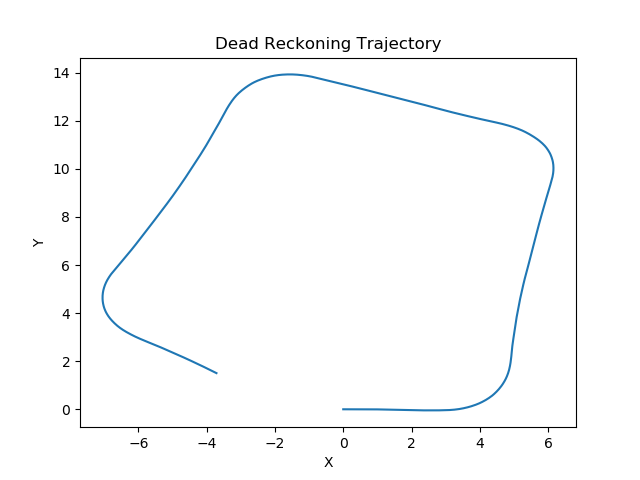

In [41]:
%matplotlib notebook
plt.title('Dead Reckoning Trajectory')
plt.ylabel('Y')
plt.xlabel('X')
plt.plot(x,y)